# Visualization Function Testing Notebook

This notebook tests the visualization functions `visualize_sample_slice` with configurable dataset and domain settings. It focuses on ground truth visualization and skips 3D visualization as requested.

## Features:
- Tests CHAOS and MMWHS datasets
- Supports CT and MR domains  
- Configurable visualization parameters
- Ground truth visualization testing
- Error handling and cleanup

In [73]:
"""
Test script for visualization functions.
Tests dataset.visualize_sample_slice with configurable dataset and domain.
Tests ground truth visualization only (3D visualization skipped).
"""

import torch
import numpy as np
from pathlib import Path
import sys

# Add src to path for imports
sys.path.append("src")

from src.datasets.registry import get_dataset

# Note: Using dataset.visualize_sample_slice() instead of standalone function

## Configuration

Change these constants to test different datasets and domains:
- **DATASET_NAME**: "CHAOS" or "MMWHS"
- **DOMAIN**: "CT" or "MR" 
- **ENCODER_TYPE**: "resnet" or "swin_unetr"
- **USE_SEMANTIC_HEAD**: Enable/disable semantic guidance

In [74]:
# Configuration constants
DATASET_NAME = "MMWHS"  # Change to "MMWHS" if needed
DOMAIN = "CT"  # Change to "CT" if needed
ENCODER_TYPE = "swin_unetr"  # Change to "swin_unetr" if needed
USE_SEMANTIC_HEAD = False  # Set to True to test semantic head
BATCH_SIZE = 1
NUM_WORKERS = 1

print("🔧 Configuration:")
print(f"   Dataset: {DATASET_NAME}")
print(f"   Domain: {DOMAIN}")
print(f"   Encoder: {ENCODER_TYPE}")
print(f"   Use Semantic Head: {USE_SEMANTIC_HEAD}")

🔧 Configuration:
   Dataset: MMWHS
   Domain: CT
   Encoder: swin_unetr
   Use Semantic Head: False


In [75]:
def preprocess(x):
    # Only scale down to (96, 128, 128) if larger
    target_shape = (96, 128, 128)
    img = x["image"].float()
    lbl = x["label"].float() if x["label"] is not None else None

    if img.shape[-3:] != target_shape:
        img = torch.nn.functional.interpolate(
            img.unsqueeze(0),
            size=target_shape,
            mode="trilinear",
            align_corners=False,
        ).squeeze(0)
        if lbl is not None:
            lbl = (
                torch.nn.functional.interpolate(
                    lbl.unsqueeze(0), size=target_shape, mode="nearest"
                )
                .squeeze(0)
                .long()
            )
    else:
        if lbl is not None:
            lbl = lbl.long()

    return {"image": img, "label": lbl}

## Ground Truth Visualization Testing

This section loads the dataset and tests the `visualize_sample_slice` function with ground truth data.

In [76]:
def test_ground_truth_visualization():
    """Test visualization functions with ground truth data."""
    print("🔍 Testing Ground Truth Visualization...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    # Load dataset
    dataset = get_dataset(
        dataset_name=DATASET_NAME,
        domain=DOMAIN,
        base_path=Path("data"),
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        preprocess=preprocess,
        slice_2d=False,  # Use 3D data
    )

    # Get a sample from the dataset
    loader = dataset.train_loader
    batch = next(iter(loader))

    # Extract a single sample
    sample = {
        "image": batch["image"],  # Keep batch dimension for inference
        "label": batch["label"],  # Keep batch dimension for inference
    }

    print(f"Sample image shape: {sample['image'].shape}")
    print(f"Sample label shape: {sample['label'].shape}")

    return dataset, sample, batch


def test_inference_and_visualization(dataset, batch):
    """Test inference with semantic head training and visualize both GT and prediction."""
    print("🚀 Testing Inference with Semantic Head Training...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Get model with semantic head
    model = dataset.get_hybrid_model(
        encoder_type=ENCODER_TYPE, use_semantic_head=USE_SEMANTIC_HEAD
    )

    # Restore the checkpoint
    checkpoint_path = Path("checkpoints", f"{DATASET_NAME}_{DOMAIN}_3d_finetuned.pth")
    finetuned_state_dict = torch.load(checkpoint_path, map_location=device).state_dict()
    model.encoder.load_state_dict(finetuned_state_dict)

    model.to(device)
    batch["image"] = batch["image"].to(device)
    batch["label"] = batch["label"].to(device)

    # Run inference
    print("🔮 Running inference...")
    outputs = model(batch["image"])
    preds = torch.argmax(outputs, dim=1, keepdim=True)

    print(f"Prediction unique values: {torch.unique(preds)}")

    return preds

In [77]:
# Run ground truth visualization test
try:
    dataset, sample, batch = test_ground_truth_visualization()
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    import traceback

    traceback.print_exc()

🔍 Testing Ground Truth Visualization...
Dataset: MMWHS, Domain: CT
Sample image shape: torch.Size([1, 1, 96, 128, 128])
Sample label shape: torch.Size([1, 1, 96, 128, 128])
✅ Dataset loaded successfully!


## Dataset Visualization Method Test

Test the `dataset.visualize_sample_slice()` method with the loaded data. This section will show both ground truth and prediction visualizations for the **same sample** to enable direct comparison. The dataset-specific implementation automatically applies the correct rotation and flip parameters for each dataset type.


📊 Testing dataset.visualize_sample_slice method...


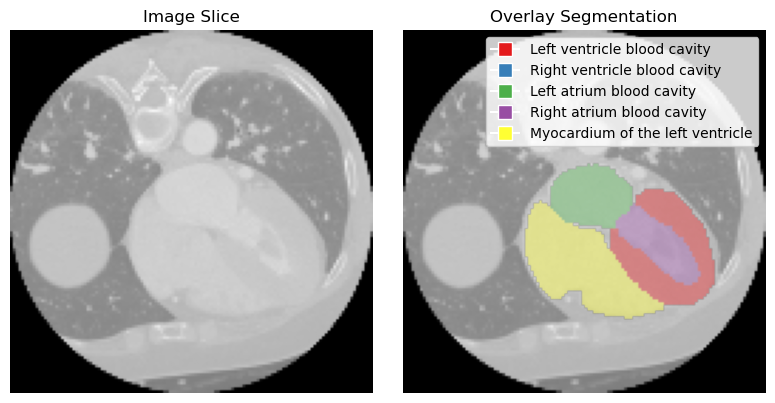

In [78]:
## Dataset Visualization Method Test

# Test dataset.visualize_sample_slice method
print("\n📊 Testing dataset.visualize_sample_slice method...")
# Squeeze batch and channel dimensions for visualization
sample["image"] = sample["image"].squeeze().permute(2, 1, 0).cpu().numpy()
sample["label"] = sample["label"].squeeze().permute(2, 1, 0).cpu().numpy()
# Use the dataset method instead of standalone function
dataset.visualize_sample_slice(sample)

In [ ]:
## Prediction Visualization

# Import required modules for safe loading
from monai.networks.nets import SwinUNETR
from monai.networks.nets.swin_unetr import SwinTransformer
from monai.networks.blocks.patchembedding import PatchEmbed
from torch.nn.modules.conv import Conv3d
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.container import ModuleList
from monai.networks.nets.swin_unetr import BasicLayer
from monai.networks.nets.swin_unetr import SwinTransformerBlock
from torch.nn.modules.normalization import LayerNorm
from monai.networks.nets.swin_unetr import WindowAttention
from torch.nn.modules.linear import Linear
from torch.nn.modules.activation import Softmax
from torch.nn.modules.linear import Identity
from monai.networks.blocks.mlp import MLPBlock
from torch.nn.modules.activation import GELU
from monai.networks.nets.swin_unetr import PatchMerging
from monai.networks.blocks.unetr_block import UnetrBasicBlock
from monai.networks.blocks.dynunet_block import UnetResBlock
from monai.networks.blocks.convolutions import Convolution
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.instancenorm import InstanceNorm3d
from monai.networks.blocks.unetr_block import UnetrUpBlock
from torch.nn.modules.conv import ConvTranspose3d
from monai.networks.blocks.dynunet_block import UnetOutBlock

# Run inference on the SAME sample
print("\n🔮 Testing dataset.visualize_sample_slice method with PREDICTIONS...")
with torch.serialization.safe_globals(
            [
                SwinUNETR,
                SwinTransformer,
                PatchEmbed,
                Conv3d,
                Dropout,
                ModuleList,
                BasicLayer,
                SwinTransformerBlock,
                LayerNorm,
                WindowAttention,
                Linear,
                Softmax,
                Identity,
                MLPBlock,
                GELU,
                PatchMerging,
                UnetrBasicBlock,
                UnetResBlock,
                Convolution,
                LeakyReLU,
                InstanceNorm3d,
                UnetrUpBlock,
                ConvTranspose3d,
                UnetOutBlock,
            ]
        ):
    # Get predictions using the same batch
    preds = test_inference_and_visualization(dataset, batch)

# Prepare prediction sample for visualization
pred_sample = {
    "image": sample["image"],
    "label": None  # Will be filled below
}

# Apply dataset-specific label mapping for predictions
if DATASET_NAME == "CHAOS":
    pred_sample["label"] = 63 * preds.squeeze().permute(2, 1, 0).cpu().numpy()
elif DATASET_NAME == "MMWHS":
    mmwhs_labels = [
        (500, "Left ventricle blood cavity", 0),
        (600, "Right ventricle blood cavity", 1),
        (420, "Left atrium blood cavity", 2),
        (550, "Right atrium blood cavity", 3),
        (205, "Myocardium of the left ventricle", 4),
        (820, "Ascending aorta", 5),
        (850, "Pulmonary artery", 6),
    ]
    label_map = {idx: code for code, _, idx in mmwhs_labels}
    pred_sample["label"] = np.vectorize(label_map.get)(
        preds.squeeze().permute(2, 1, 0).cpu().numpy()
    )

print("Prediction unique values:", np.unique(pred_sample["label"]))
# Use the dataset method for prediction visualization
dataset.visualize_sample_slice(pred_sample)


🔮 Testing dataset.visualize_sample_slice method with PREDICTIONS...
🚀 Testing Inference with Semantic Head Training...
Dataset: MMWHS, Domain: CT
Using device: cpu
2025-07-20 13:05:33,608 - INFO - Expected md5 is None, skip md5 check for file data/ssl_pretrained_weights.pth.
2025-07-20 13:05:33,609 - INFO - File exists: data/ssl_pretrained_weights.pth, skipped downloading.
Total updated layers 159 / 159
Pretrained Weights Succesfully Loaded !
🔮 Running inference...
Prediction unique values: tensor([0, 1, 2, 3, 4])


AttributeError: 'numpy.ndarray' object has no attribute 'permute'